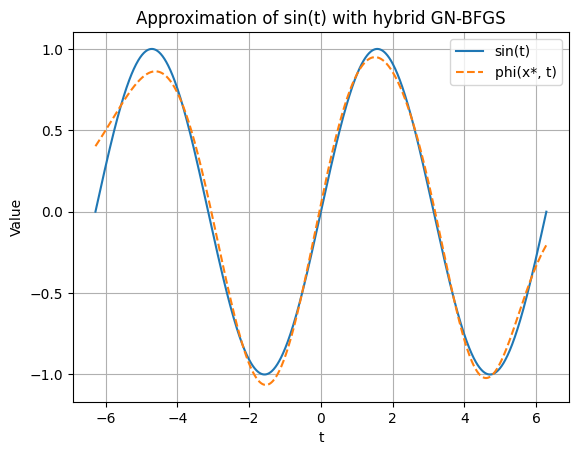

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import line_search

# Constants
l = 4
m = 100
a_vals = np.linspace(-2 * np.pi, 2 * np.pi, m)
b_vals = np.sin(a_vals)

# ================================
# Gaussian model and its Jacobian
# ================================

def phi(x, t_vals):
    result = np.zeros_like(t_vals)
    for i in range(l):
        alpha = x[3 * i]
        mu = x[3 * i + 1]
        sigma = x[3 * i + 2]
        result += alpha * np.exp(-((t_vals - mu) ** 2) / (2 * sigma ** 2))
    return result

def residual(x):
    return phi(x, a_vals) - b_vals

def jacobian(x):
    J = np.zeros((m, 3 * l))
    for j, t in enumerate(a_vals):
        for i in range(l):
            alpha = x[3 * i]
            mu = x[3 * i + 1]
            sigma = x[3 * i + 2]
            exp_term = np.exp(-((t - mu) ** 2) / (2 * sigma ** 2))
            d_alpha = exp_term
            d_mu = alpha * exp_term * (t - mu) / (sigma ** 2)
            d_sigma = alpha * exp_term * ((t - mu) ** 2) / (sigma ** 3)
            J[j, 3 * i] = d_alpha
            J[j, 3 * i + 1] = d_mu
            J[j, 3 * i + 2] = d_sigma
    return J

# ======================
# Hybrid GN-BFGS method
# ======================

def hybrid_gn_bfgs(x0, max_iter=100, tol=1e-6):
    x = x0.copy()
    r = residual(x)
    J = jacobian(x)
    H = J.T @ J  # Initial GN approximation
    g = J.T @ r

    history = [x.copy()]

    for k in range(max_iter):
        # Solve for descent direction
        try:
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            print("Hessian not invertible.")
            break

        # Backtracking line search (Armijo)
        alpha = 1.0
        c = 1e-4
        rho = 0.5
        f0 = 0.5 * np.dot(r, r)
        while True:
            x_new = x + alpha * p
            r_new = residual(x_new)
            f_new = 0.5 * np.dot(r_new, r_new)
            if f_new <= f0 + c * alpha * np.dot(g, p):
                break
            alpha *= rho

        s = alpha * p
        x += s
        r_new = residual(x)
        J_new = jacobian(x)
        g_new = J_new.T @ r_new
        y = g_new - g

        # BFGS update
        ys = y @ s
        if ys > 1e-10:  # ensure positive definiteness
            Hs = H @ s
            H += np.outer(y, y) / ys - np.outer(Hs, Hs) / (s @ Hs)

        g = g_new
        r = r_new
        J = J_new
        history.append(x.copy())

        if np.linalg.norm(g) < tol:
            break

    return x, history

# ==================================
# Run an example with visualization
# ==================================

x0 = np.random.randn(3 * l)  # Random initial guess
x_star, history = hybrid_gn_bfgs(x0)

# Plot final result
t_vals_plot = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
plt.plot(t_vals_plot, np.sin(t_vals_plot), label='sin(t)')
plt.plot(t_vals_plot, phi(x_star, t_vals_plot), label='phi(x*, t)', linestyle='--')
plt.legend()
plt.title('Approximation of sin(t) with hybrid GN-BFGS')
plt.xlabel('t')
plt.ylabel('Value')
plt.grid(True)
plt.show()


5 Runs:

In [15]:
import time

np.random.seed(42)

def evaluate_runs(x_star, num_runs=5, scales=[0.5, 1.0, 1.5, 2.0, 3.0]):
    for i, scale in enumerate(scales[:num_runs]):
        print(f"\n--- Run {i + 1} (scale = {scale}) ---")
        x0 = np.random.randn(3 * l) * scale
        start_time = time.time()
        x_final, history = hybrid_gn_bfgs(x0)
        end_time = time.time()
        runtime = end_time - start_time

        distance = np.linalg.norm(x_final - x_star)
        k = len(history) - 2
        if k < 0:
            print("Insufficient iterations for convergence analysis.")
            continue

        xk = history[k]
        xk1 = history[k + 1]
        lk = np.linalg.norm(xk1 - x_star) / np.linalg.norm(xk - x_star)
        qk = np.linalg.norm(xk1 - x_star) / (np.linalg.norm(xk - x_star) ** 2)

        print(f"Stopping criterion: ||g|| < 1e-6 or max_iter = 100")
        print(f"Final iterate x̄:\n{x_final}")
        print(f"Distance to x*: {distance:.6f}")
        print(f"ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = {lk:.6f}")
        print(f"q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = {qk:.6f}")
        print(f"Runtime: {runtime:.4f} seconds")

        # Plotting result
        plt.figure()
        plt.plot(a_vals, b_vals, label="sin(t)")
        plt.plot(a_vals, phi(x_final, a_vals), '--', label="phi(x̄; t)")
        plt.title(f"Run {i + 1}: phi(x̄; t) vs sin(t)")
        plt.xlabel("t")
        plt.ylabel("Function value")
        plt.legend()
        plt.grid(True)
        plt.show()



--- Run 1 (scale = 0.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-0.54615037 -2.25144508 -0.41509814 -0.93448951 -1.24451312  0.64026597
  0.94458913  1.26573874 -0.65316265  0.51300812  2.26025437 -0.40432904]
Distance to x*: 204.299128
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 0.999970
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.004894
Runtime: 0.1839 seconds


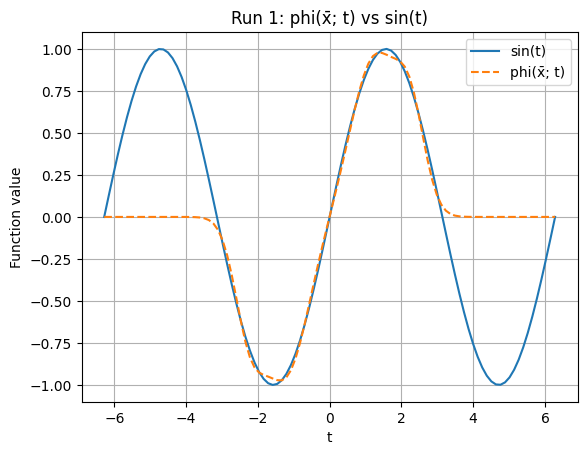


--- Run 2 (scale = 1.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-4.99992871e+05 -1.76017480e+06  1.60238937e+05 -1.32071598e+00
 -1.57078957e+00  8.02799943e-01  9.46740972e+04  3.98968246e+05
  5.40211312e+04  5.36664395e+05  1.23801576e+06  2.27901857e+05]
Distance to x*: 2327588.869006
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.015048
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.000000
Runtime: 0.1782 seconds


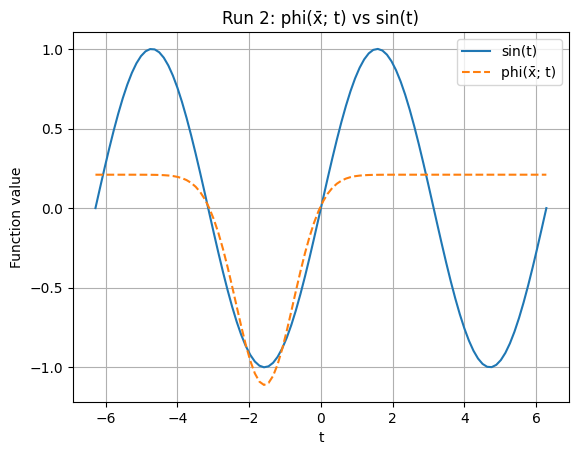


--- Run 3 (scale = 1.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-0.89887765  0.19439239 -1.73245496  0.56349903 -0.90096337 -0.43749907
  2.92157496  2.76566055 -0.02944755 -1.51108919  1.27416811 -1.82582634]
Distance to x*: 205.705053
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.000000
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.004861
Runtime: 0.6385 seconds


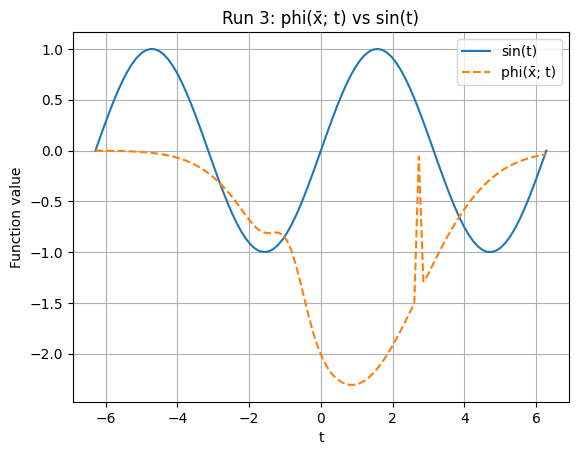


--- Run 4 (scale = 2.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 1.11093882 -4.57710095  0.77387482  1.07181227  1.53387493  0.86633622
 -1.08232395  4.65519538 -0.85651333 -0.94074199 -1.66256897  1.00924751]
Distance to x*: 207.919240
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 0.999917
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.004809
Runtime: 0.1920 seconds


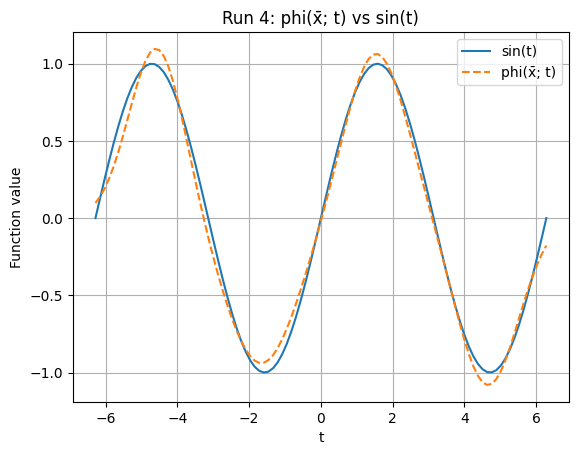


--- Run 5 (scale = 3.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 4.54677998 -4.44051328  1.7036849  -5.77892919  4.53072152  1.80763247
  4.82741986  4.24007642 -2.68560948 -3.66102968 -3.9084139  -2.70929783]
Distance to x*: 209.435652
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.000364
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.004778
Runtime: 0.1915 seconds


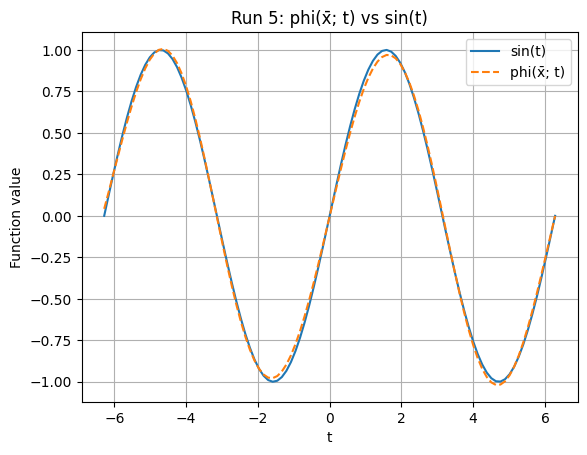

In [19]:
np.random.seed(42)
evaluate_runs(x_star)


Comparison with standard Newton Method:


=== Run 1 with scale 0.1 ===
GN-BFGS: Obj=0.284260, Dist=12.743459, Time=0.3138s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=0.446281, Dist=0.805511, Time=4.5285s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


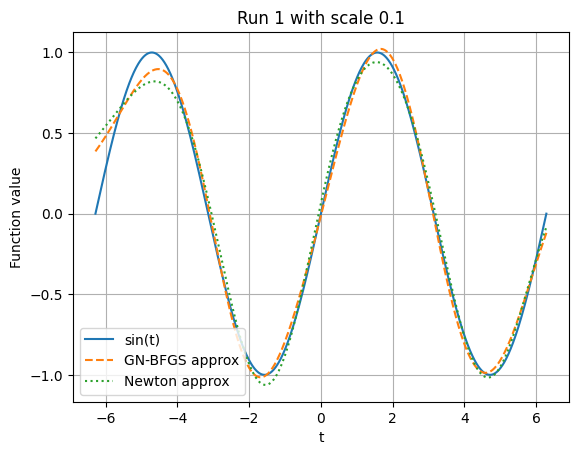


=== Run 2 with scale 0.25 ===
GN-BFGS: Obj=0.284872, Dist=10.781349, Time=0.1802s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=0.692401, Dist=2.001944, Time=3.3061s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


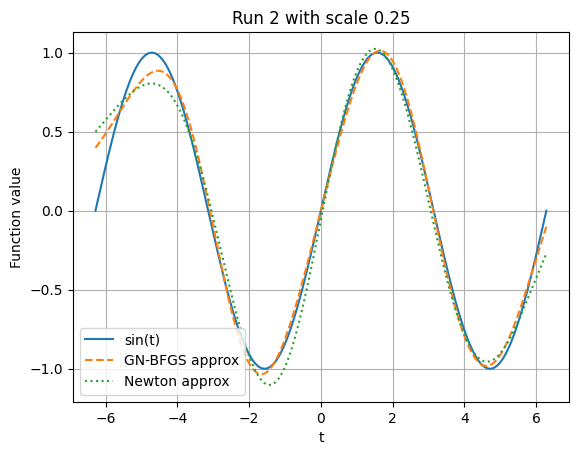


=== Run 3 with scale 0.5 ===
GN-BFGS: Obj=0.288372, Dist=31.398044, Time=0.1801s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=2.374568, Dist=4.868548, Time=3.4231s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


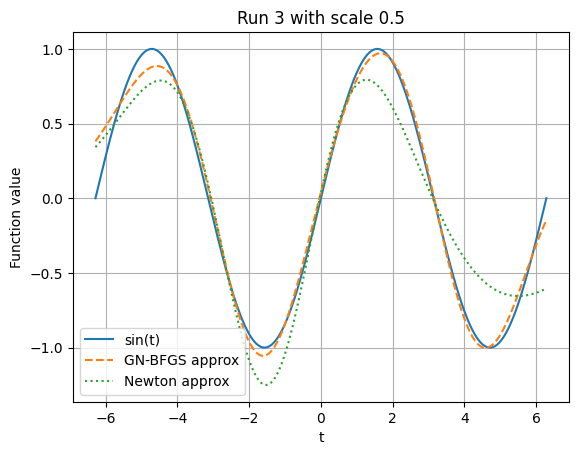


=== Run 4 with scale 0.75 ===
GN-BFGS: Obj=17.067216, Dist=3606508.030886, Time=0.1994s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=24.061265, Dist=39.106817, Time=3.5888s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


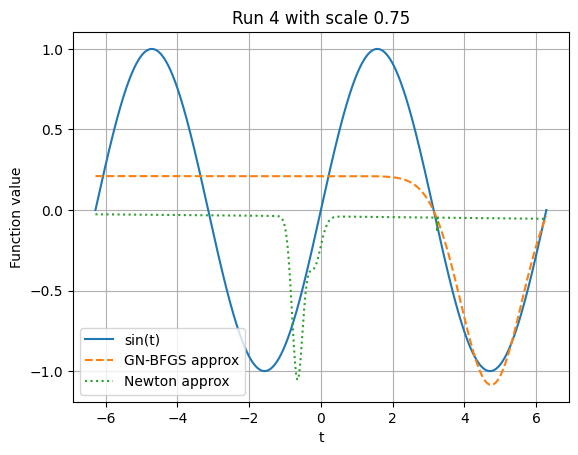


=== Run 5 with scale 1.0 ===
GN-BFGS: Obj=7.761999, Dist=2407.949155, Time=0.3042s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=22.416389, Dist=20.162889, Time=3.7011s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


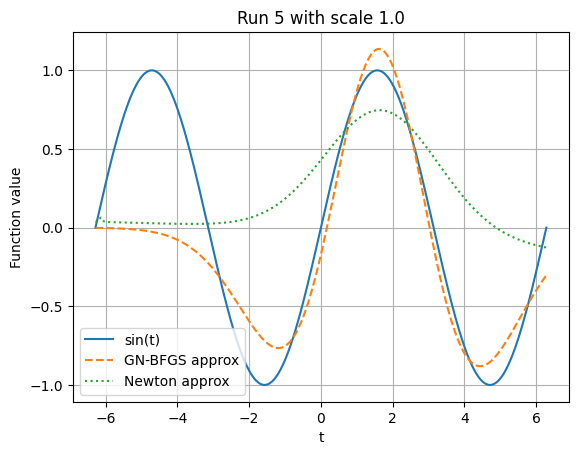


=== Run 6 with scale 1.5 ===
GN-BFGS: Obj=23.951089, Dist=1224060.101601, Time=0.3363s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=21.230198, Dist=9.748474, Time=3.4877s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


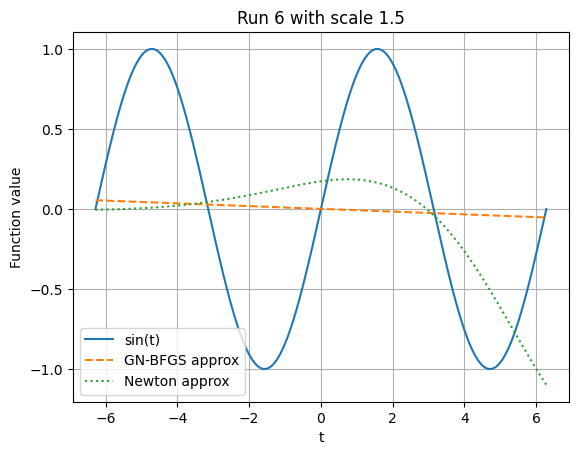


=== Run 7 with scale 2.0 ===
GN-BFGS: Obj=0.719266, Dist=21.638198, Time=0.1811s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=24.441979, Dist=12.780959, Time=3.7685s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


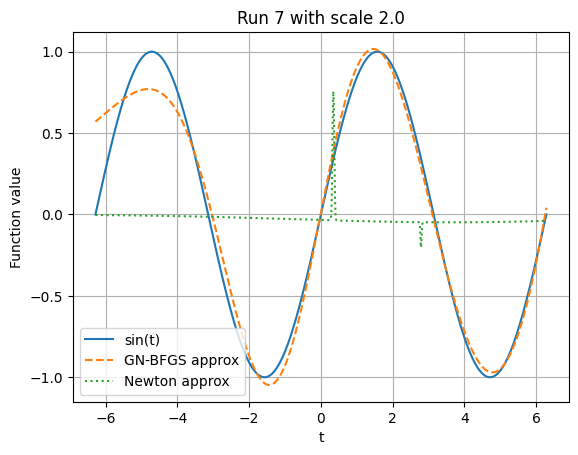


=== Run 8 with scale 2.5 ===
GN-BFGS: Obj=0.355558, Dist=338.511774, Time=0.2735s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=21.014985, Dist=8.101356, Time=3.3162s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


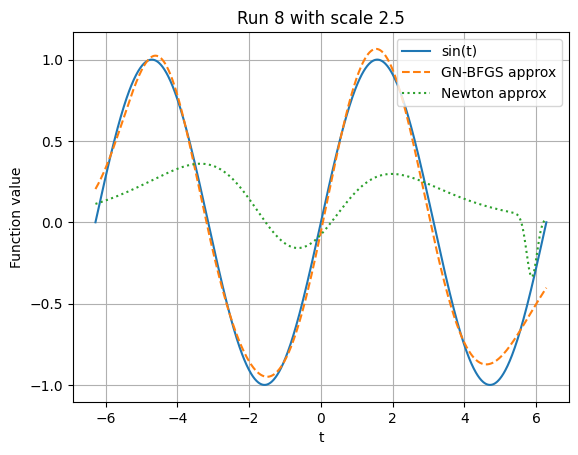


=== Run 9 with scale 3.0 ===
GN-BFGS: Obj=6.422660, Dist=27.671088, Time=0.1701s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=21.644805, Dist=21.114288, Time=3.1186s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


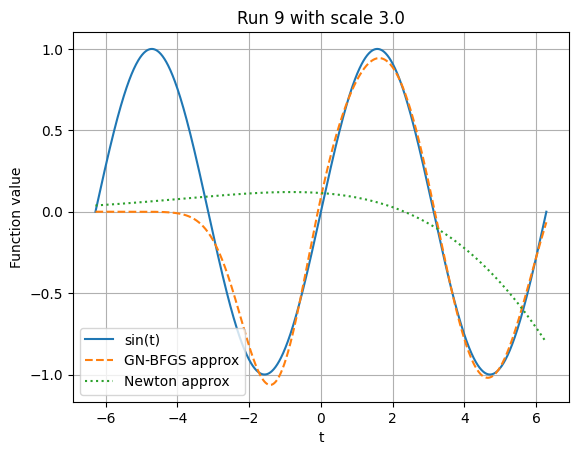


=== Run 10 with scale 4.0 ===
GN-BFGS: Obj=17.046682, Dist=4319.086554, Time=0.1963s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=20.193155, Dist=10.591742, Time=3.5828s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


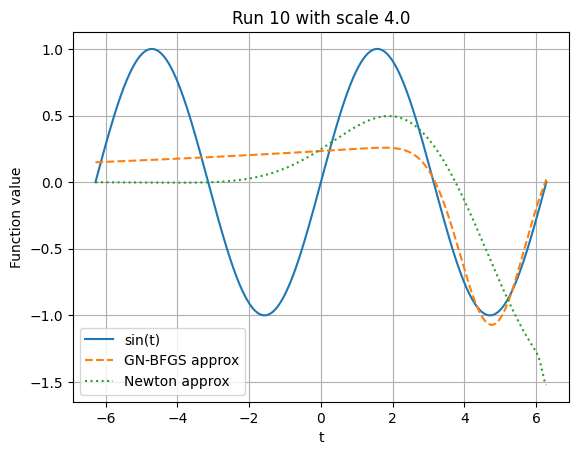

In [20]:
from scipy.optimize import approx_fprime
import time

np.random.seed(42)

def objective_function(x):
    r = residual(x)
    return 0.5 * np.dot(r, r)

def numerical_hessian(f, x, epsilon=1e-5):
    n = len(x)
    hess = np.zeros((n, n))
    fx = f(x)
    for i in range(n):
        x1 = x.copy()
        x1[i] += epsilon
        grad1 = approx_fprime(x1, f, epsilon)
        x2 = x.copy()
        x2[i] -= epsilon
        grad2 = approx_fprime(x2, f, epsilon)
        hess[:, i] = (grad1 - grad2) / (2 * epsilon)
    return (hess + hess.T) / 2  # Make symmetric

def newton_method(x0, max_iter=100, tol=1e-6):
    x = x0.copy()
    history = [x.copy()]

    for k in range(max_iter):
        r = residual(x)
        J = jacobian(x)
        g = J.T @ r
        if np.linalg.norm(g) < tol:
            break

        H = numerical_hessian(objective_function, x)

        try:
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            print("Hessian not invertible.")
            break

        # Line search
        alpha = 1.0
        c = 1e-4
        rho = 0.5
        f0 = objective_function(x)
        while True:
            x_new = x + alpha * p
            f_new = objective_function(x_new)
            if f_new <= f0 + c * alpha * g @ p:
                break
            alpha *= rho

        x += alpha * p
        history.append(x.copy())

    return x, history

def classify_convergence(history, x_star):
    linear_counts = 0
    superlinear_counts = 0
    quadratic_counts = 0
    n = len(history)

    # We analyze the last few steps, say last 5 steps (if available)
    start_idx = max(0, n - 6)

    for k in range(start_idx, n - 2):
        xk = history[k]
        xk1 = history[k + 1]
        xk2 = history[k + 2]

        dist_k = np.linalg.norm(xk - x_star)
        dist_k1 = np.linalg.norm(xk1 - x_star)
        dist_k2 = np.linalg.norm(xk2 - x_star)

        if dist_k == 0 or dist_k1 == 0:
            continue

        # Linear ratio
        ell_k = dist_k1 / dist_k
        # Quadratic ratio
        q_k = dist_k2 / (dist_k1 ** 2)

        # Classify
        # Thresholds can be tuned depending on your problem
        if ell_k < 0.9:
            if 0.1 < q_k < 10:
                quadratic_counts += 1
            else:
                superlinear_counts += 1
        else:
            linear_counts += 1

    return linear_counts, superlinear_counts, quadratic_counts


def evaluate_both_methods(x_star, scales):
    np.random.seed(42)  # For reproducibility

    for i, scale in enumerate(scales):
        print(f"\n=== Run {i+1} with scale {scale} ===")

        x0 = x_star + np.random.randn(3 * l) * scale

        # Hybrid GN-BFGS
        start = time.time()
        x_gn, hist_gn = hybrid_gn_bfgs(x0)
        time_gn = time.time() - start
        obj_gn = objective_function(x_gn)
        dist_gn = np.linalg.norm(x_gn - x_star)

        # Compute convergence rates for GN-BFGS
        lin_gn, superlin_gn, quad_gn = classify_convergence(hist_gn, x_star)

        # Newton method
        start = time.time()
        try:
            x_newton, hist_newton = newton_method(x0)
            newton_failed = False
        except Exception as e:
            print(f"Newton failed with error: {e}")
            x_newton = None
            hist_newton = []
            newton_failed = True
        time_newton = time.time() - start

        if not newton_failed:
            obj_newton = objective_function(x_newton)
            dist_newton = np.linalg.norm(x_newton - x_star)
            lin_newton, superlin_newton, quad_newton = classify_convergence(hist_newton, x_star)
        else:
            obj_newton = None
            dist_newton = None
            lin_newton = superlin_newton = quad_newton = None

        print(f"GN-BFGS: Obj={obj_gn:.6f}, Dist={dist_gn:.6f}, Time={time_gn:.4f}s, "
              f"Convergence rates: Linear={lin_gn}, Superlinear={superlin_gn}, Quadratic={quad_gn}")

        if not newton_failed:
            print(f"Newton: Obj={obj_newton:.6f}, Dist={dist_newton:.6f}, Time={time_newton:.4f}s, "
                  f"Convergence rates: Linear={lin_newton}, Superlinear={superlin_newton}, Quadratic={quad_newton}")
        else:
            print(f"Newton method failed to converge.")

        # Plot results for this run
        t_plot = np.linspace(-2*np.pi, 2*np.pi, 1000)
        plt.plot(t_plot, np.sin(t_plot), label='sin(t)')
        plt.plot(t_plot, phi(x_gn, t_plot), '--', label='GN-BFGS approx')
        if not newton_failed:
            plt.plot(t_plot, phi(x_newton, t_plot), ':', label='Newton approx')
        plt.title(f"Run {i+1} with scale {scale}")
        plt.xlabel("t")
        plt.ylabel("Function value")
        plt.legend()
        plt.grid(True)
        plt.show()


x0 = np.random.randn(3 * l)
for i in range(l):
    x0[3*i + 2] = np.abs(x0[3*i + 2]) + 0.1  # make sure sigma > 0.1 initially
x_star_approx, _ = hybrid_gn_bfgs(x0)
scales = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]

evaluate_both_methods(x_star_approx, scales)


